In [47]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')
import pickle

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


#  Load Engineered Data

In [36]:

df = pd.read_csv('/Users/nazmul/Desktop/Project/ucl/data/ucl_stats_engineered.csv')
print(f"Dataset loaded: {df.shape}")
print(f"\nColumns: {list(df.columns)}")

# Separate features and target
X = df.drop(columns=['champions'])
y = df['champions']

print(f"\n Features: {X.shape}")
print(f" Target: {y.shape}")
print(f"\nClass distribution:")
print(y.value_counts())
print(f"\nClass imbalance ratio: {(y==0).sum()}:{(y==1).sum()}")


Dataset loaded: (685, 23)

Columns: ['matches_played', 'wins', 'draws', 'losses', 'goals_scored', 'goals_conceded', 'goal_diff', 'group_point', 'champions', 'win_ratio', 'loss_ratio', 'draw_ratio', 'goals_scored_per_match', 'goals_conceded_per_match', 'win_to_loss_ratio', 'goal_efficiency', 'defensive_strength', 'points_per_match', 'goal_difference_per_match', 'clean_sheet_potential', 'dominance_score', 'team_encoded', 'league_encoded']

 Features: (685, 22)
 Target: (685,)

Class distribution:
champions
0    658
1     27
Name: count, dtype: int64

Class imbalance ratio: 658:27


# Handle Class Imbalance with SMOTE

In [37]:

print("=" * 70)
print("HANDLING CLASS IMBALANCE")
print("=" * 70)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42, k_neighbors=3)
X_balanced, y_balanced = smote.fit_resample(X, y)

print(f"\n Original dataset:")
print(f"   Champions: {(y==1).sum()}")
print(f"   Non-champions: {(y==0).sum()}")

print(f"\n Balanced dataset:")
print(f"   Champions: {(y_balanced==1).sum()}")
print(f"   Non-champions: {(y_balanced==0).sum()}")



HANDLING CLASS IMBALANCE

 Original dataset:
   Champions: 27
   Non-champions: 658

 Balanced dataset:
   Champions: 658
   Non-champions: 658


# Split Data and Scale Features

In [38]:

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print(f"\n Data split:")
print(f"   Training: {X_train.shape}")
print(f"   Testing: {X_test.shape}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler
with open('/Users/nazmul/Desktop/Project/ucl/models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print(" Features scaled and scaler saved")


 Data split:
   Training: (1052, 22)
   Testing: (264, 22)
 Features scaled and scaler saved


# Train Random Forest Model

In [39]:

print("\n" + "=" * 70)
print("TRAINING RANDOM FOREST")
print("=" * 70)

# Define parameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Grid search
rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(
    rf, rf_param_grid, cv=5, scoring='f1', 
    n_jobs=-1, verbose=1
)
rf_grid.fit(X_train_scaled, y_train)

print(f"\n Best Random Forest parameters:")
print(rf_grid.best_params_)

# Save model
rf_best = rf_grid.best_estimator_
with open('/Users/nazmul/Desktop/Project/ucl/models/random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_best, f)

# Predictions
y_pred_rf = rf_best.predict(X_test_scaled)
y_pred_rf_proba = rf_best.predict_proba(X_test_scaled)[:, 1]

print(f"\n Random Forest Metrics:")
print(f"   Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"   Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"   Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"   F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"   ROC-AUC: {roc_auc_score(y_test, y_pred_rf_proba):.4f}")



TRAINING RANDOM FOREST
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

 Best Random Forest parameters:
{'class_weight': 'balanced', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

 Random Forest Metrics:
   Accuracy: 0.9773
   Precision: 0.9565
   Recall: 1.0000
   F1-Score: 0.9778
   ROC-AUC: 0.9987


# Train KNN Model

In [40]:

print("\n" + "=" * 70)
print("TRAINING K-NEAREST NEIGHBORS")
print("=" * 70)

# Define parameter grid
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Grid search
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(
    knn, knn_param_grid, cv=5, scoring='f1',
    n_jobs=-1, verbose=1
)
knn_grid.fit(X_train_scaled, y_train)

print(f"\n Best KNN parameters:")
print(knn_grid.best_params_)
# Save model
knn_best = knn_grid.best_estimator_
with open('/Users/nazmul/Desktop/Project/ucl/models/knn_model.pkl', 'wb') as f:
    pickle.dump(knn_best, f)

# Predictions
y_pred_knn = knn_best.predict(X_test_scaled)
y_pred_knn_proba = knn_best.predict_proba(X_test_scaled)[:, 1]

print(f"\n KNN Metrics:")
print(f"   Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"   Precision: {precision_score(y_test, y_pred_knn):.4f}")
print(f"   Recall: {recall_score(y_test, y_pred_knn):.4f}")
print(f"   F1-Score: {f1_score(y_test, y_pred_knn):.4f}")
print(f"   ROC-AUC: {roc_auc_score(y_test, y_pred_knn_proba):.4f}")



TRAINING K-NEAREST NEIGHBORS
Fitting 5 folds for each of 30 candidates, totalling 150 fits

 Best KNN parameters:
{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}

 KNN Metrics:
   Accuracy: 0.9659
   Precision: 0.9362
   Recall: 1.0000
   F1-Score: 0.9670
   ROC-AUC: 0.9846


# Train XGBoost Model

In [41]:


print("\n" + "=" * 70)
print("TRAINING XGBOOST")
print("=" * 70)

# Define parameter grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'scale_pos_weight': [1, 5, 10]  # For handling class imbalance
}

# Grid search - REMOVED use_label_encoder parameter
xgb = XGBClassifier(
    random_state=42, 
    eval_metric='logloss',
    enable_categorical=False,
    verbosity=0  # Suppress XGBoost's own warnings
)

xgb_grid = GridSearchCV(
    xgb, xgb_param_grid, cv=5, scoring='f1',
    n_jobs=-1, verbose=1
)

print("\n Starting Grid Search (this may take a few minutes)...")
xgb_grid.fit(X_train_scaled, y_train)

print(f"\n Best XGBoost parameters:")
for param, value in xgb_grid.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n Best cross-validation F1 score: {xgb_grid.best_score_:.4f}")

# Save model
xgb_best = xgb_grid.best_estimator_
with open('/Users/nazmul/Desktop/Project/ucl/models/xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_best, f)
print("\n Model saved to 'models/xgboost_model.pkl'")

# Predictions
y_pred_xgb = xgb_best.predict(X_test_scaled)
y_pred_xgb_proba = xgb_best.predict_proba(X_test_scaled)[:, 1]

print(f"\n XGBoost Test Set Metrics:")
print(f"   Accuracy:  {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"   Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"   Recall:    {recall_score(y_test, y_pred_xgb):.4f}")
print(f"   F1-Score:  {f1_score(y_test, y_pred_xgb):.4f}")
print(f"   ROC-AUC:   {roc_auc_score(y_test, y_pred_xgb_proba):.4f}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print(f"\n📊 Confusion Matrix:")
print(f"   True Negatives:  {cm_xgb[0][0]}")
print(f"   False Positives: {cm_xgb[0][1]}")
print(f"   False Negatives: {cm_xgb[1][0]}")
print(f"   True Positives:  {cm_xgb[1][1]}")


TRAINING XGBOOST

 Starting Grid Search (this may take a few minutes)...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

 Best XGBoost parameters:
   learning_rate: 0.1
   max_depth: 3
   n_estimators: 300
   scale_pos_weight: 1
   subsample: 0.9

 Best cross-validation F1 score: 0.9850

 Model saved to 'models/xgboost_model.pkl'

 XGBoost Test Set Metrics:
   Accuracy:  0.9735
   Precision: 0.9496
   Recall:    1.0000
   F1-Score:  0.9742
   ROC-AUC:   0.9940

📊 Confusion Matrix:
   True Negatives:  125
   False Positives: 7
   False Negatives: 0
   True Positives:  132


# Create Ensemble Model

In [42]:

print("\n" + "=" * 70)
print("CREATING ENSEMBLE MODEL")
print("=" * 70)

# Weighted average ensemble (soft voting)
# Give more weight to better performing models based on F1-scores
rf_f1 = f1_score(y_test, y_pred_rf)
knn_f1 = f1_score(y_test, y_pred_knn)
xgb_f1 = f1_score(y_test, y_pred_xgb)

total_f1 = rf_f1 + knn_f1 + xgb_f1
rf_weight = rf_f1 / total_f1
knn_weight = knn_f1 / total_f1
xgb_weight = xgb_f1 / total_f1

print(f"Model Weights (based on F1-score):")
print(f"   Random Forest: {rf_weight:.4f}")
print(f"   KNN: {knn_weight:.4f}")
print(f"   XGBoost: {xgb_weight:.4f}")

# Ensemble predictions (weighted average of probabilities)
y_pred_ensemble_proba = (
    rf_weight * y_pred_rf_proba +
    knn_weight * y_pred_knn_proba +
    xgb_weight * y_pred_xgb_proba
)
y_pred_ensemble = (y_pred_ensemble_proba >= 0.5).astype(int)

print(f"\n Ensemble Model Metrics:")
print(f"   Accuracy: {accuracy_score(y_test, y_pred_ensemble):.4f}")
print(f"   Precision: {precision_score(y_test, y_pred_ensemble):.4f}")
print(f"   Recall: {recall_score(y_test, y_pred_ensemble):.4f}")
print(f"   F1-Score: {f1_score(y_test, y_pred_ensemble):.4f}")
print(f"   ROC-AUC: {roc_auc_score(y_test, y_pred_ensemble_proba):.4f}")

# Save ensemble weights
ensemble_config = {
    'rf_weight': rf_weight,
    'knn_weight': knn_weight,
    'xgb_weight': xgb_weight
}
with open('/Users/nazmul/Desktop/Project/ucl/models/ensemble_config.pkl', 'wb') as f:
    pickle.dump(ensemble_config, f)



CREATING ENSEMBLE MODEL
Model Weights (based on F1-score):
   Random Forest: 0.3350
   KNN: 0.3313
   XGBoost: 0.3337

 Ensemble Model Metrics:
   Accuracy: 0.9735
   Precision: 0.9496
   Recall: 1.0000
   F1-Score: 0.9742
   ROC-AUC: 0.9997


# Compare All Models


MODEL COMPARISON
        Model  Accuracy  Precision  Recall  F1-Score
Random Forest  0.977273   0.956522     1.0  0.977778
          KNN  0.965909   0.936170     1.0  0.967033
      XGBoost  0.973485   0.949640     1.0  0.974170
     Ensemble  0.973485   0.949640     1.0  0.974170


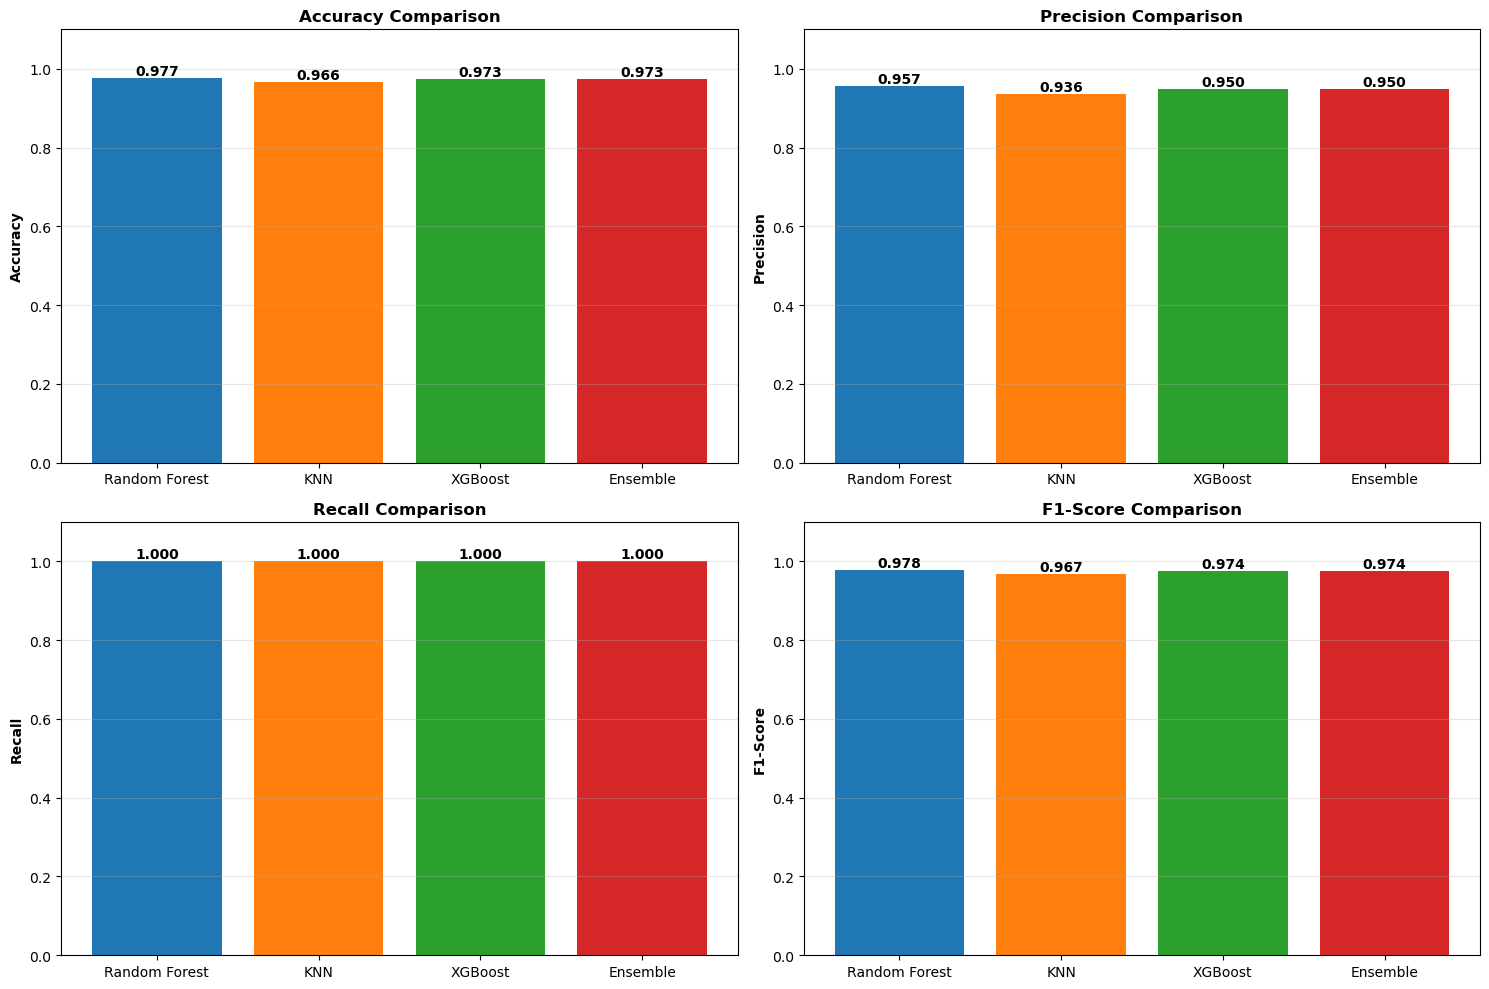


 Comparison chart saved to 'model_comparison.png'


In [43]:

print("\n" + "=" * 70)
print("MODEL COMPARISON")
print("=" * 70)

comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'KNN', 'XGBoost', 'Ensemble'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_ensemble)
    ],
    'Precision': [
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_knn),
        precision_score(y_test, y_pred_xgb),
        precision_score(y_test, y_pred_ensemble)
    ],
    'Recall': [
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_knn),
        recall_score(y_test, y_pred_xgb),
        recall_score(y_test, y_pred_ensemble)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_knn),
        f1_score(y_test, y_pred_xgb),
        f1_score(y_test, y_pred_ensemble)
    ]
})

print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, (ax, metric) in enumerate(zip(axes.flat, metrics)):
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], 
                   color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax.set_ylabel(metric, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontweight='bold', fontsize=12)
    ax.set_ylim([0, 1.1])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('/Users/nazmul/Desktop/Project/ucl/visualizations/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Comparison chart saved to 'model_comparison.png'")

# Confusion matrices

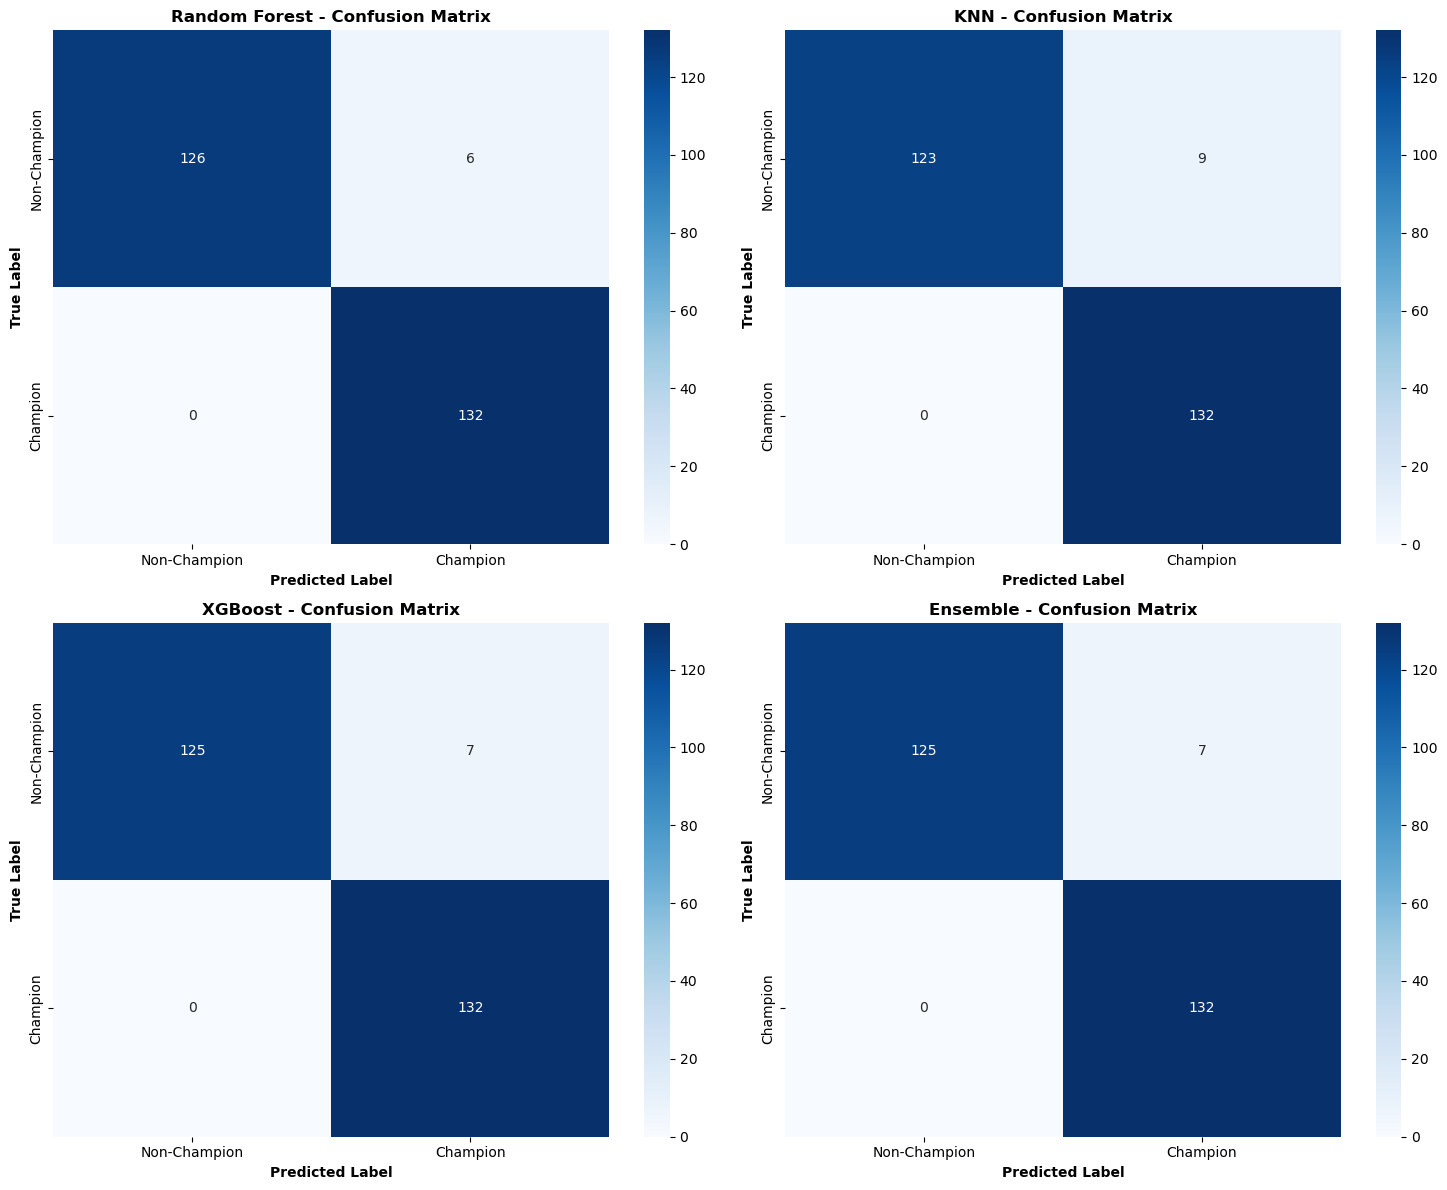

 Confusion matrices saved to 'confusion_matrices.png'


In [44]:

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

models = ['Random Forest', 'KNN', 'XGBoost', 'Ensemble']
predictions = [y_pred_rf, y_pred_knn, y_pred_xgb, y_pred_ensemble]

for ax, model_name, y_pred in zip(axes.flat, models, predictions):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Non-Champion', 'Champion'],
                yticklabels=['Non-Champion', 'Champion'])
    ax.set_title(f'{model_name} - Confusion Matrix', fontweight='bold', fontsize=12)
    ax.set_ylabel('True Label', fontweight='bold')
    ax.set_xlabel('Predicted Label', fontweight='bold')

plt.tight_layout()
plt.savefig('/Users/nazmul/Desktop/Project/ucl/visualizations/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Confusion matrices saved to 'confusion_matrices.png'")


# Feature Importance (Random Forest)



TOP 10 MOST IMPORTANT FEATURES (Random Forest)
                  Feature  Importance
        win_to_loss_ratio    0.190414
               loss_ratio    0.134327
                win_ratio    0.078888
                goal_diff    0.078846
           matches_played    0.078804
goal_difference_per_match    0.062100
             goals_scored    0.047783
                     wins    0.047514
       defensive_strength    0.046959
         points_per_match    0.040869


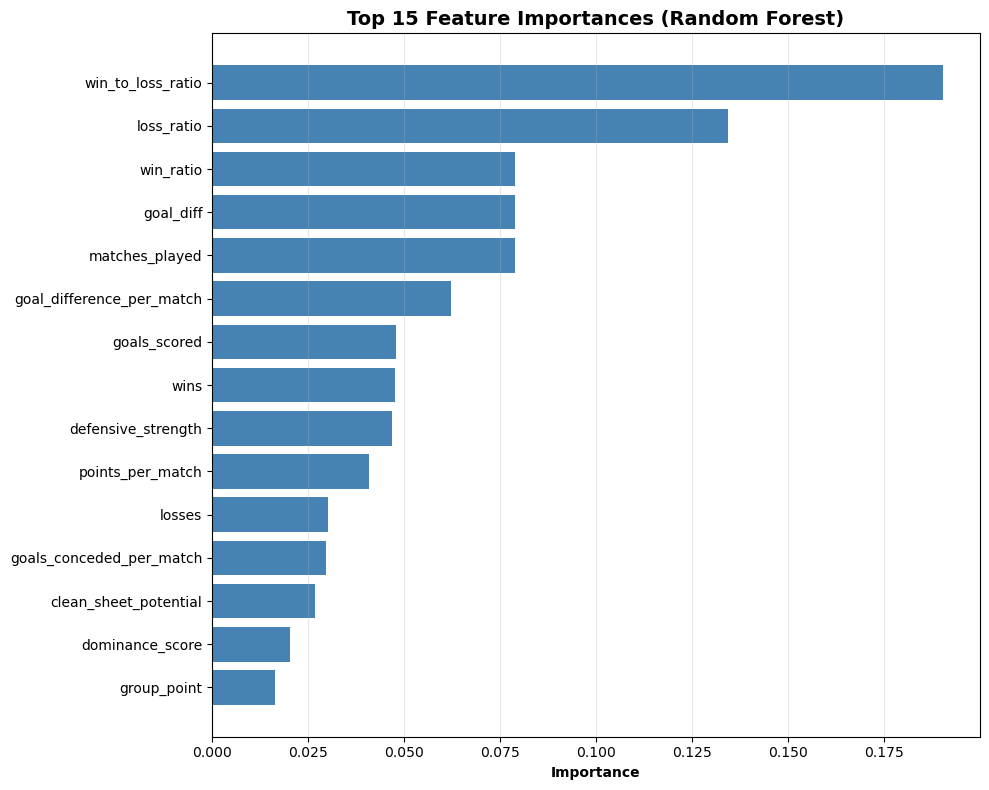


 Feature importance chart saved to 'feature_importance.png'


In [45]:

feature_names = X.columns
feature_importance = rf_best.feature_importances_
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\n" + "=" * 70)
print("TOP 10 MOST IMPORTANT FEATURES (Random Forest)")
print("=" * 70)
print(feature_df.head(10).to_string(index=False))

# Visualize top 15 features
plt.figure(figsize=(10, 8))
top_features = feature_df.head(15)
plt.barh(top_features['Feature'], top_features['Importance'], color='steelblue')
plt.xlabel('Importance', fontweight='bold')
plt.title('Top 15 Feature Importances (Random Forest)', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('/Users/nazmul/Desktop/Project/ucl/visualizations/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Feature importance chart saved to 'feature_importance.png'")



# ROC Curves

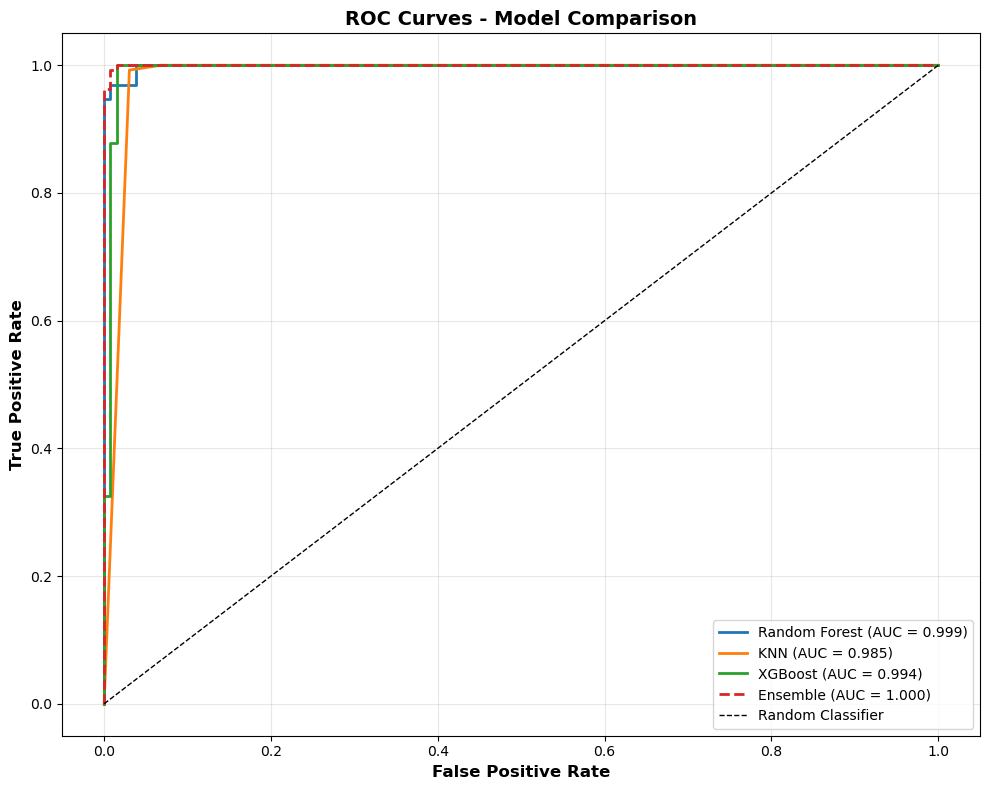

 ROC curves saved to 'roc_curves.png'

MODEL TRAINING COMPLETE

 All models trained and saved


In [46]:

plt.figure(figsize=(10, 8))

# Plot ROC curves for all models
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_proba)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_knn_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb_proba)
fpr_ens, tpr_ens, _ = roc_curve(y_test, y_pred_ensemble_proba)

plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_pred_rf_proba):.3f})',
         linewidth=2)
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_score(y_test, y_pred_knn_proba):.3f})',
         linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_pred_xgb_proba):.3f})',
         linewidth=2)
plt.plot(fpr_ens, tpr_ens, label=f'Ensemble (AUC = {roc_auc_score(y_test, y_pred_ensemble_proba):.3f})',
         linewidth=2, linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate', fontweight='bold', fontsize=12)
plt.ylabel('True Positive Rate', fontweight='bold', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontweight='bold', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('/Users/nazmul/Desktop/Project/ucl/visualizations/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(" ROC curves saved to 'roc_curves.png'")

print("\n" + "=" * 70)
print("MODEL TRAINING COMPLETE")
print("=" * 70)
print("\n All models trained and saved")
